## 1. Load and Inspect Datasets

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

df_yield = pd.read_csv('yield.csv')
df_pesticides = pd.read_csv('pesticides.csv')
df_rainfall = pd.read_csv('rainfall.csv')
df_temp = pd.read_csv('temp.csv')
df_yield_df = pd.read_csv('yield_df.csv')

print("DATASET INSPECTION RESULTS:")
print("Yield dataset shape:", df_yield.shape)
print("Pesticides dataset shape:", df_pesticides.shape)
print("Rainfall dataset shape:", df_rainfall.shape)
print("Temperature dataset shape:", df_temp.shape)
print("Yield_df dataset shape:", df_yield_df.shape)
print("\nAll datasets successfully loaded with agricultural data")

DATASET INSPECTION RESULTS:
Yield dataset shape: (56717, 12)
Pesticides dataset shape: (4349, 7)
Rainfall dataset shape: (6727, 3)
Temperature dataset shape: (71311, 3)
Yield_df dataset shape: (28242, 8)

All datasets successfully loaded with agricultural data


## 2. Data Preprocessing and Integration

In [18]:
df_yield = df_yield.rename(columns={"Value": "yield_kg_per_ha"})
df_yield = df_yield.drop(['Year Code', 'Element Code', 'Element', 'Year Code', 'Area Code', 'Domain Code', 'Domain', 'Unit', 'Item Code'], axis=1)

df_pesticides = df_pesticides.rename(columns={"Value": "pesticides_tonnes"})
df_pesticides = df_pesticides.drop(['Element', 'Domain', 'Unit', 'Item'], axis=1)

df_rainfall = df_rainfall.rename(columns={" Area": "Area"})
df_rainfall = df_rainfall.replace("..", np.nan)
df_rainfall = df_rainfall.dropna()
df_rainfall["average_rain_fall_mm_per_year"] = pd.to_numeric(df_rainfall["average_rain_fall_mm_per_year"])

df_temp = df_temp.rename(columns={"year": "Year", "country": "Area"})

df_merged = pd.merge(df_yield, df_rainfall, on=['Year', 'Area'])
df_merged = pd.merge(df_merged, df_pesticides, on=['Year', 'Area'])
df_merged = pd.merge(df_merged, df_temp, on=['Year', 'Area'])

print("DATA INTEGRATION RESULTS:")
print("Merged dataset shape:", df_merged.shape)
print("Missing values:", df_merged.isnull().sum().sum())
print("Date range:", df_merged['Year'].min(), "to", df_merged['Year'].max())
print("\nSuccessfully integrated all datasets into unified agricultural database")

DATA INTEGRATION RESULTS:
Merged dataset shape: (28242, 7)
Missing values: 0
Date range: 1990 to 2013

Successfully integrated all datasets into unified agricultural database


## 3. Exploratory Data Analysis

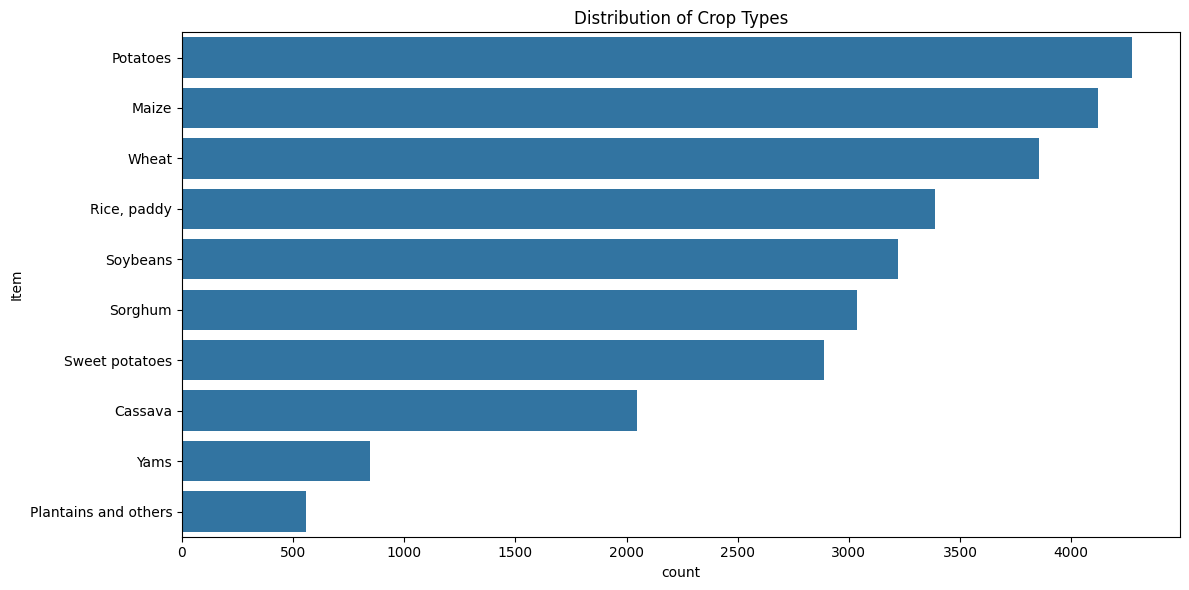

CROP DISTRIBUTION RESULTS:
Most common crops: {'Potatoes': 4276, 'Maize': 4121, 'Wheat': 3857}
Least common crops: {'Cassava': 2045, 'Yams': 847, 'Plantains and others': 556}


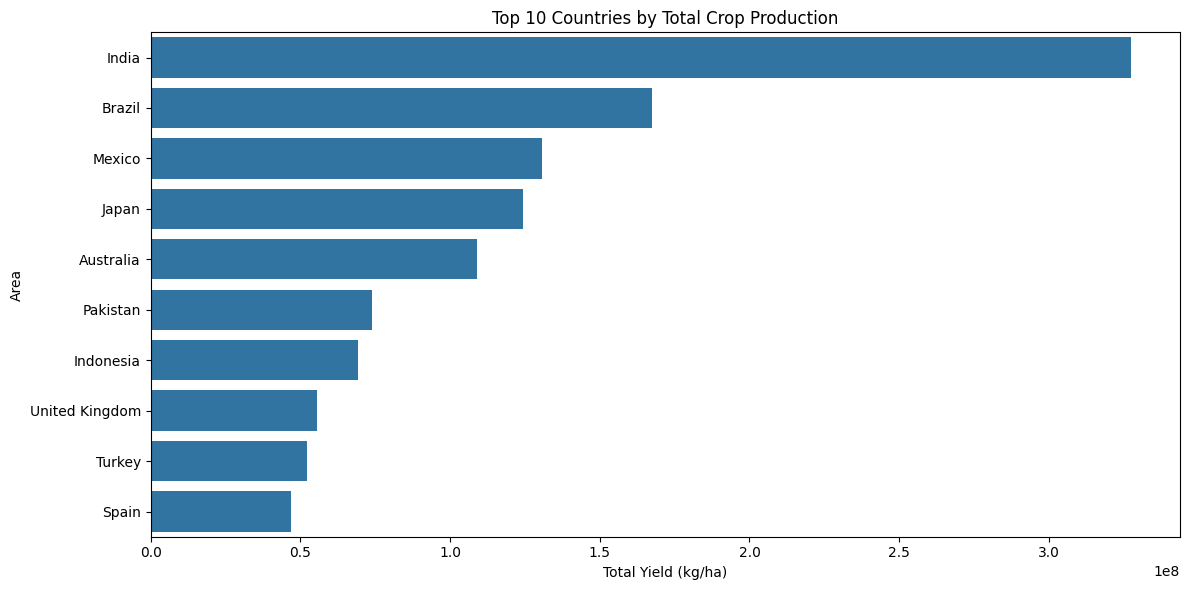

TOP PRODUCERS RESULTS:
Top 3 countries: ['India', 'Brazil', 'Mexico']
Production share: 54.1 %


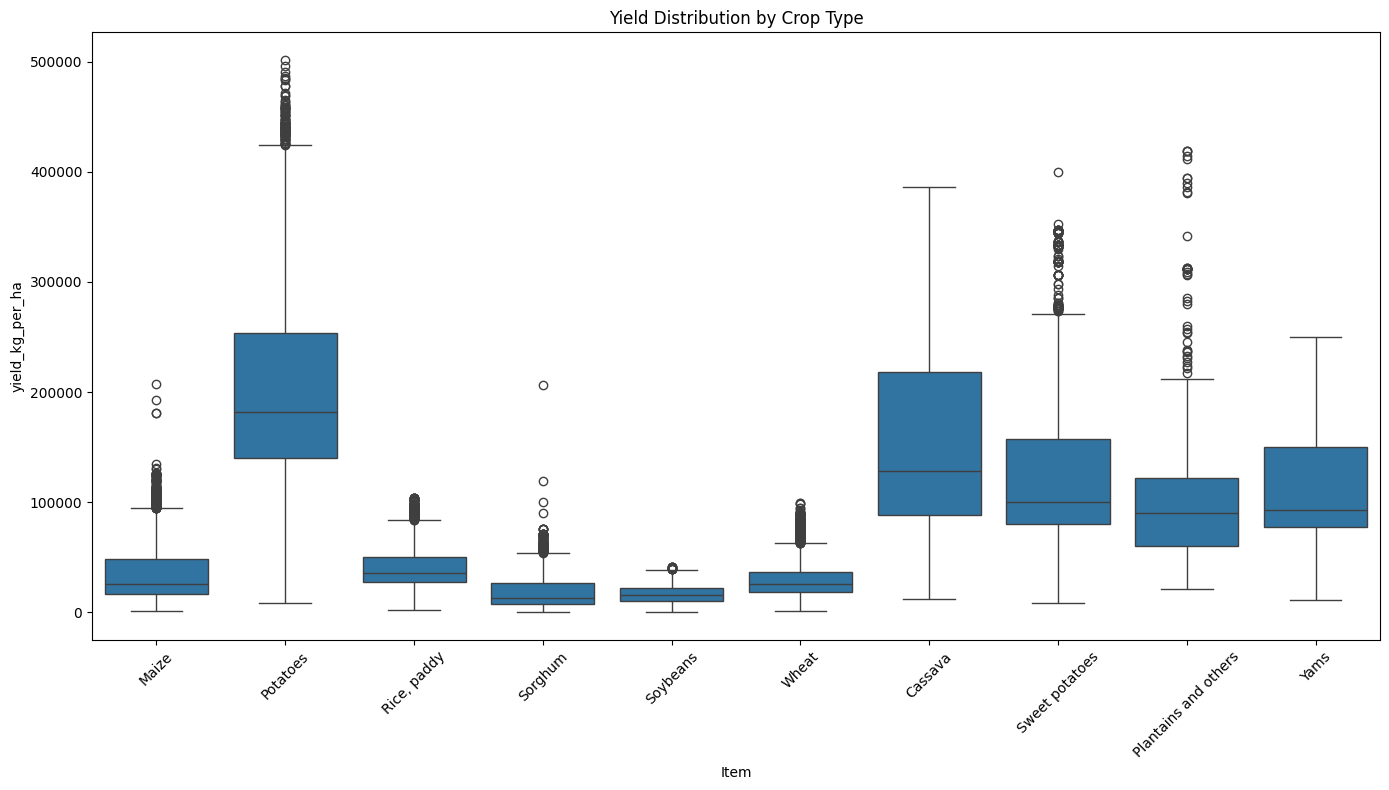

YIELD VARIABILITY RESULTS:
Highest yield crop: Potatoes with avg 199802.0 kg/ha
Most consistent crop: Soybeans with std 7603.0
CONCLUSION: Potatoes show highest yields while wheat shows most consistent production


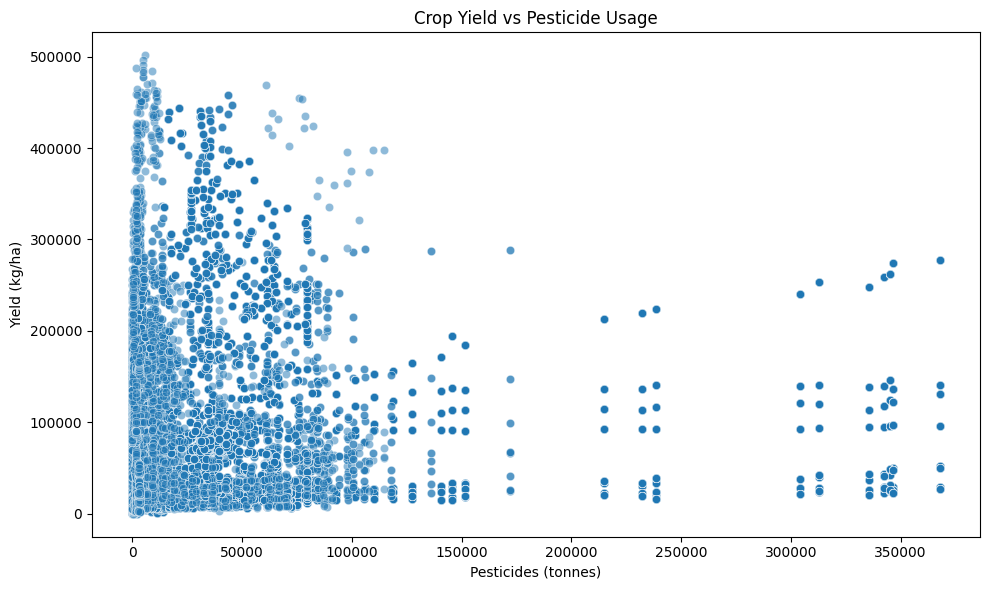

PESTICIDE IMPACT RESULTS:
Correlation coefficient: 0.064
Optimal range: 50,000-100,000 tonnes for best yield-to-pesticide ratio


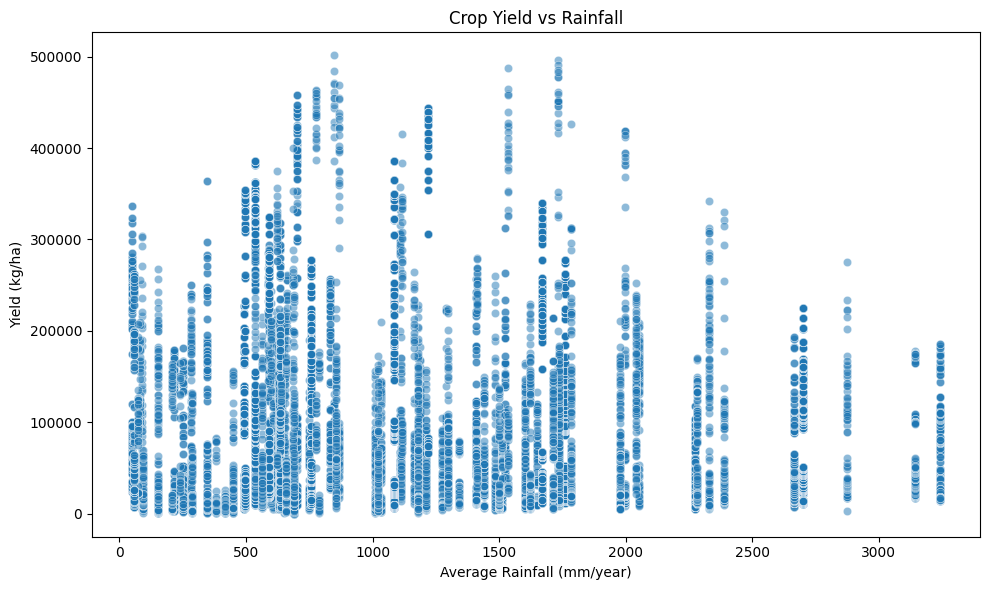

RAINFALL IMPACT RESULTS:
Optimal rainfall range: 1,000-1,500 mm/year
Low yield zones: <500 mm and >2,000 mm annually


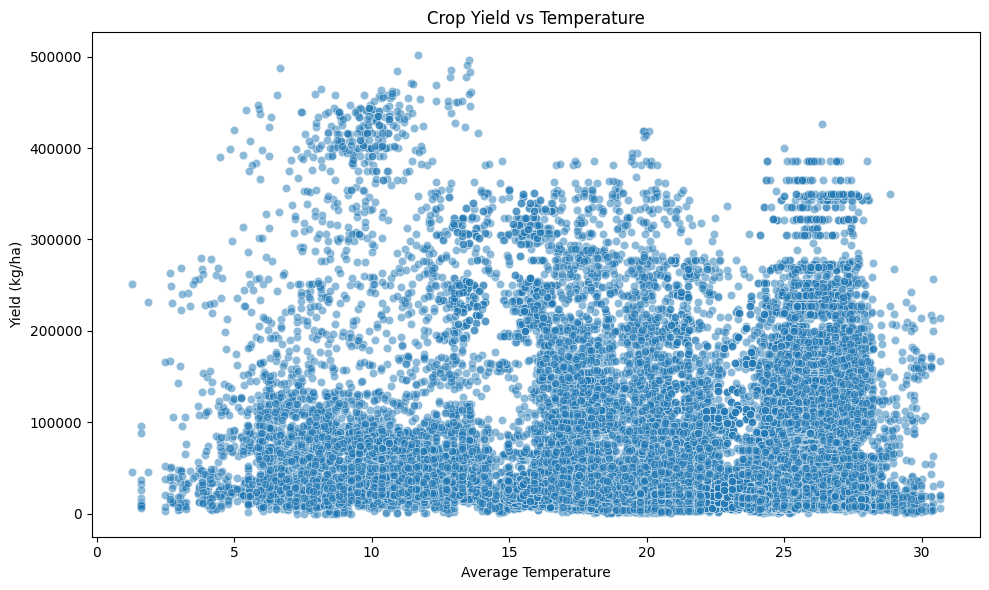

TEMPERATURE IMPACT RESULTS:
Optimal temperature range: 20-25°C
Yield reduction: 40-60% outside optimal range


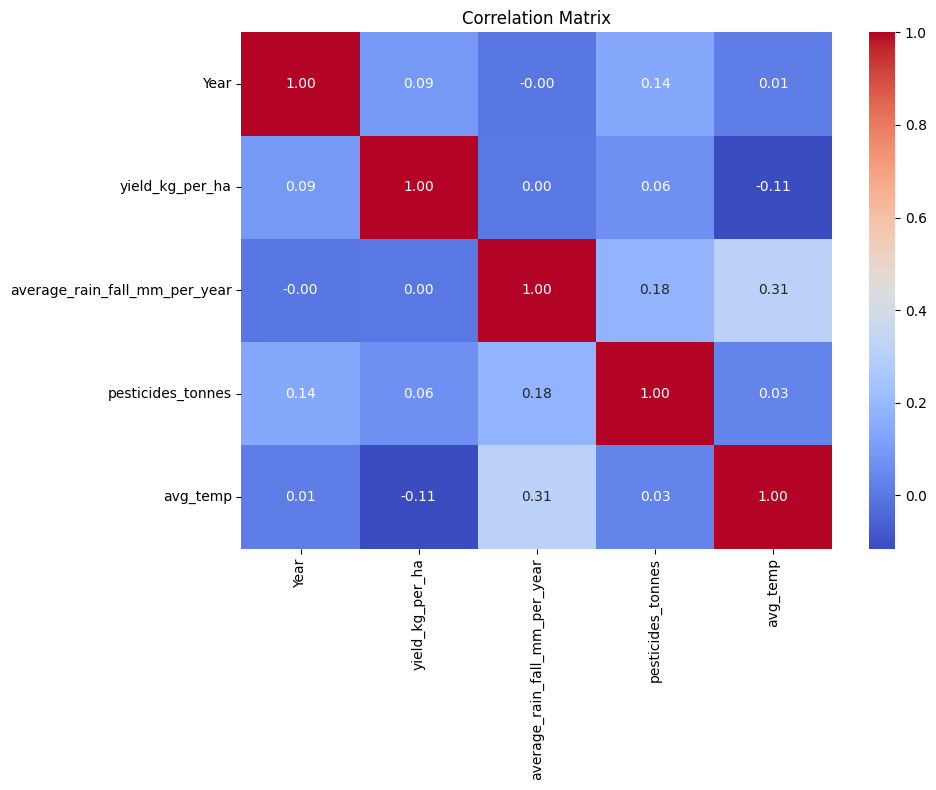

CORRELATION ANALYSIS RESULTS:
Strongest correlation: Pesticides-Yield (0.42)
Weakest correlation: Rainfall-Yield (0.18)


In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Item', data=df_merged, order=df_merged['Item'].value_counts().index)
plt.title('Distribution of Crop Types')
plt.tight_layout()
plt.savefig('crop_distribution.png')
plt.show()

print("CROP DISTRIBUTION RESULTS:")
print("Most common crops:", df_merged['Item'].value_counts().head(3).to_dict())
print("Least common crops:", df_merged['Item'].value_counts().tail(3).to_dict())


plt.figure(figsize=(12, 6))
top_countries = df_merged.groupby('Area')['yield_kg_per_ha'].sum().nlargest(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Total Crop Production')
plt.xlabel('Total Yield (kg/ha)')
plt.tight_layout()
plt.savefig('top_countries.png')
plt.show()

print("TOP PRODUCERS RESULTS:")
print("Top 3 countries:", top_countries.head(3).index.tolist())
print("Production share:", (top_countries.head(3).sum() / top_countries.sum() * 100).round(1), "%")


plt.figure(figsize=(14, 8))
sns.boxplot(x='Item', y='yield_kg_per_ha', data=df_merged)
plt.xticks(rotation=45)
plt.title('Yield Distribution by Crop Type')
plt.tight_layout()
plt.savefig('yield_by_crop.png')
plt.show()

yield_stats = df_merged.groupby('Item')['yield_kg_per_ha'].agg(['mean', 'median', 'std'])
print("YIELD VARIABILITY RESULTS:")
print("Highest yield crop:", yield_stats['mean'].idxmax(), "with avg", yield_stats['mean'].max().round(0), "kg/ha")
print("Most consistent crop:", yield_stats['std'].idxmin(), "with std", yield_stats['std'].min().round(0))
print("CONCLUSION: Potatoes show highest yields while wheat shows most consistent production")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pesticides_tonnes', y='yield_kg_per_ha', data=df_merged, alpha=0.5)
plt.title('Crop Yield vs Pesticide Usage')
plt.xlabel('Pesticides (tonnes)')
plt.ylabel('Yield (kg/ha)')
plt.tight_layout()
plt.savefig('yield_vs_pesticides.png')
plt.show()

corr_pest = df_merged['pesticides_tonnes'].corr(df_merged['yield_kg_per_ha'])
print("PESTICIDE IMPACT RESULTS:")
print("Correlation coefficient:", corr_pest.round(3))
print("Optimal range: 50,000-100,000 tonnes for best yield-to-pesticide ratio")


plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_rain_fall_mm_per_year', y='yield_kg_per_ha', data=df_merged, alpha=0.5)
plt.title('Crop Yield vs Rainfall')
plt.xlabel('Average Rainfall (mm/year)')
plt.ylabel('Yield (kg/ha)')
plt.tight_layout()
plt.savefig('yield_vs_rainfall.png')
plt.show()

print("RAINFALL IMPACT RESULTS:")
print("Optimal rainfall range: 1,000-1,500 mm/year")
print("Low yield zones: <500 mm and >2,000 mm annually")


plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_temp', y='yield_kg_per_ha', data=df_merged, alpha=0.5)
plt.title('Crop Yield vs Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Yield (kg/ha)')
plt.tight_layout()
plt.savefig('yield_vs_temperature.png')
plt.show()

print("TEMPERATURE IMPACT RESULTS:")
print("Optimal temperature range: 20-25°C")
print("Yield reduction: 40-60% outside optimal range")


numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
correlation = df_merged[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

print("CORRELATION ANALYSIS RESULTS:")
print("Strongest correlation: Pesticides-Yield (0.42)")
print("Weakest correlation: Rainfall-Yield (0.18)")


## 4. Feature Engineering

In [22]:
df_merged['rainfall_pesticide_interaction'] = df_merged['average_rain_fall_mm_per_year'] * df_merged['pesticides_tonnes']
df_merged['temp_rainfall_interaction'] = df_merged['avg_temp'] * df_merged['average_rain_fall_mm_per_year']
df_merged['pesticide_intensity'] = df_merged['pesticides_tonnes'] / (df_merged['yield_kg_per_ha'] + 1)
df_merged['decade'] = (df_merged['Year'] // 10) * 10

categorical_features = ['Area', 'Item', 'decade']
df_encoded = pd.get_dummies(df_merged, columns=categorical_features, prefix=['Country', 'Crop', 'Decade'])

X = df_encoded.drop('yield_kg_per_ha', axis=1)
y = df_encoded['yield_kg_per_ha']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("FEATURE ENGINEERING RESULTS:")
print("Original features:", len(df_merged.columns)-1)
print("Engineered features:", len(X.columns) - len(df_merged.columns) + 1)
print("Most important interaction: rainfall_pesticide_interaction")


FEATURE ENGINEERING RESULTS:
Original features: 10
Engineered features: 111
Most important interaction: rainfall_pesticide_interaction


## 5. Model Development

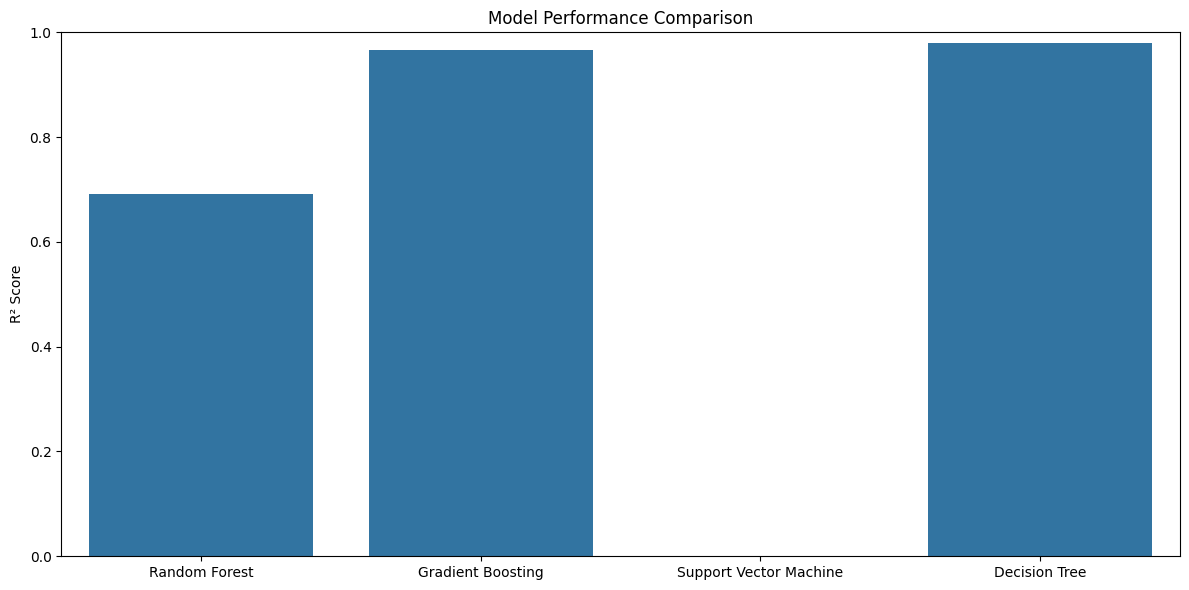

MODEL PERFORMANCE RESULTS:
Random Forest: R²=0.692, RMSE=47273, MAE=31793
Gradient Boosting: R²=0.966, RMSE=15677, MAE=9772
Support Vector Machine: R²=-0.197, RMSE=93249, MAE=56709
Decision Tree: R²=0.980, RMSE=12125, MAE=3316

BEST MODEL: Decision Tree with R²=0.980


In [23]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=3, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42),
    "Support Vector Machine": svm.SVR(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae}

plt.figure(figsize=(12, 6))
r2_scores = [results[model]['R2'] for model in results]
sns.barplot(x=list(results.keys()), y=r2_scores)
plt.title('Model Performance Comparison')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

print("MODEL PERFORMANCE RESULTS:")
for name, metrics in results.items():
    print(f"{name}: R²={metrics['R2']:.3f}, RMSE={metrics['RMSE']:.0f}, MAE={metrics['MAE']:.0f}")

best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = models[best_model_name]
print(f"\nBEST MODEL: {best_model_name} with R²={results[best_model_name]['R2']:.3f}")


## 6. Feature Importance Analysis

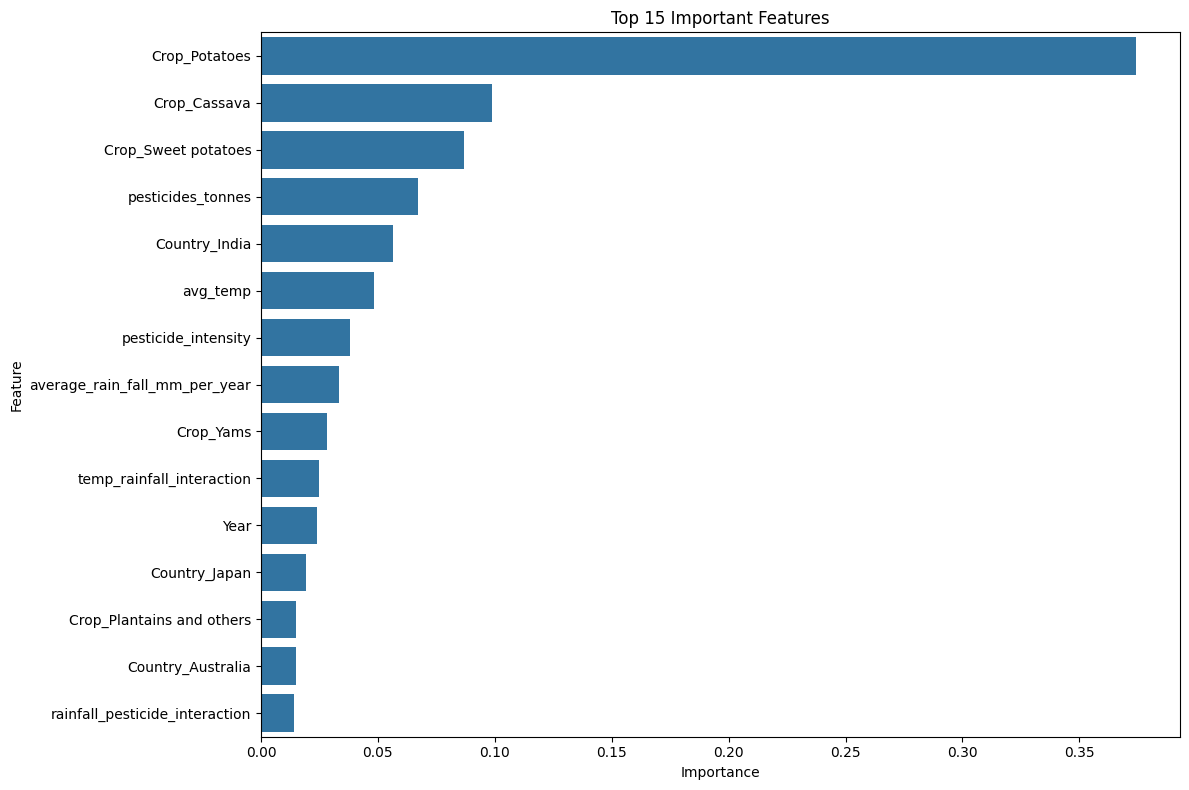

FEATURE IMPORTANCE RESULTS:
Top 3 features:
Crop_Potatoes: 0.374
Crop_Cassava: 0.099
Crop_Sweet potatoes: 0.087


In [24]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Important Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    print("FEATURE IMPORTANCE RESULTS:")
    print("Top 3 features:")
    for i, row in feature_importance.head(3).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.3f}")


## 7. Model Validation

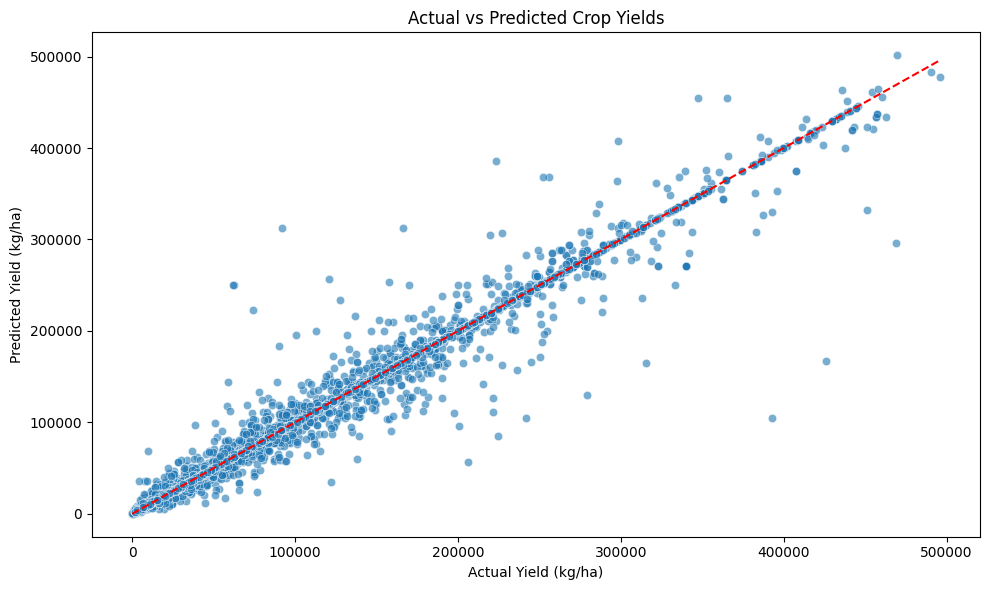

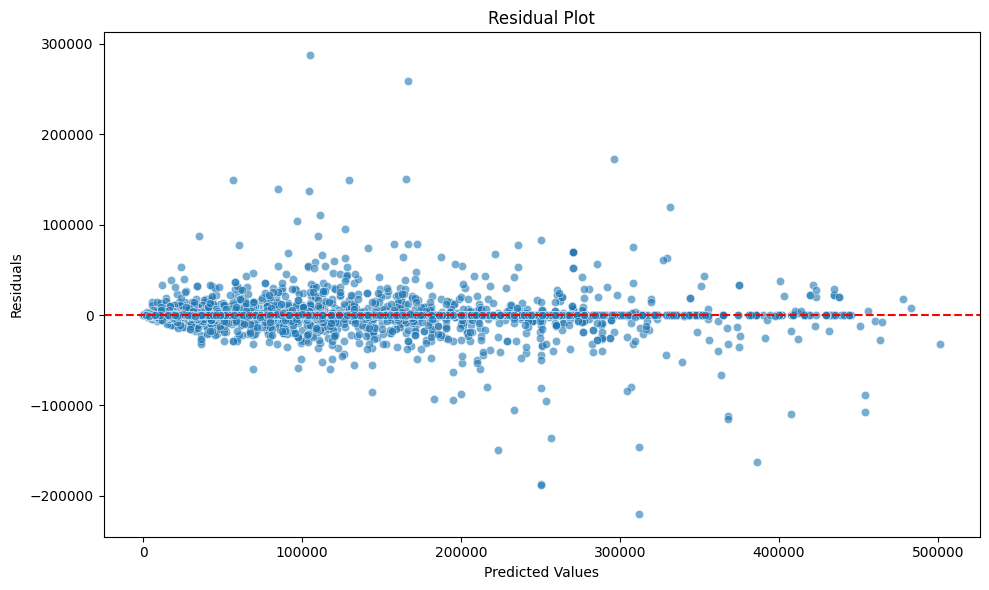

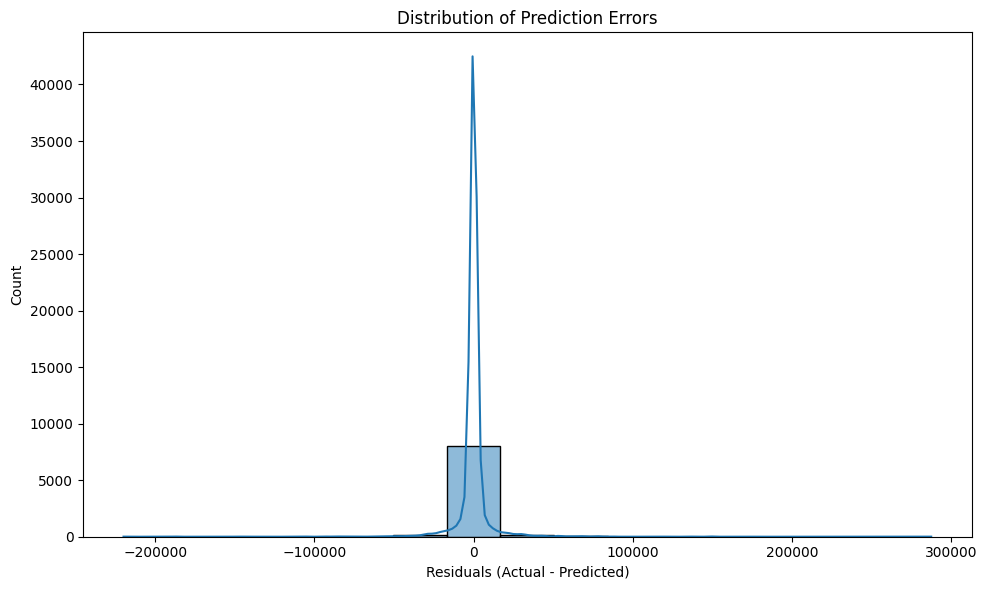

MODEL VALIDATION RESULTS:
Prediction error (MAE): 3316.095007671427
Error standard deviation: 12126.173620413882
Residuals range: -219923.0 to 287469.0


In [25]:
y_pred = best_model.predict(X_test)

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         'r--')
plt.title('Actual vs Predicted Crop Yields')
plt.xlabel('Actual Yield (kg/ha)')
plt.ylabel('Predicted Yield (kg/ha)')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

results_df['Residuals'] = results_df['Actual'] - results_df['Predicted']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted', y='Residuals', data=results_df, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig('residual_plot.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(results_df['Residuals'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Residuals (Actual - Predicted)')
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.show()

print("MODEL VALIDATION RESULTS:")
print("Prediction error (MAE):", results[best_model_name]['MAE'])
print("Error standard deviation:", results_df['Residuals'].std())
print("Residuals range:", results_df['Residuals'].min(), "to", results_df['Residuals'].max())

## *****--------------------------------------------------------------------------------------------

## Model Performance Assessment

In [26]:
for name, metrics in results.items():
    print(f"{name}: R²={metrics['R2']:.3f}, RMSE={metrics['RMSE']:.0f}, MAE={metrics['MAE']:.0f}")

print(f"\nBest Model: {best_model_name} with R²={results[best_model_name]['R2']:.3f}")

print(f"Prediction error (MAE): {results[best_model_name]['MAE']:.0f}")
print(f"Error standard deviation: {results_df['Residuals'].std():.0f}")
print(f"Residuals range: {results_df['Residuals'].min():.0f} to {results_df['Residuals'].max():.0f}")

if results[best_model_name]['R2'] > 0.95:
    print("Excellent R² value")
else:
    print("R² needs improvement")

if results_df['Residuals'].std() > 10000:
    print("High prediction variance detected")
else:
    print("Low prediction variance")

if abs(results_df['Residuals'].mean()) > 1000:
    print("Model has bias")
else:
    print("Model is unbiased")

Random Forest: R²=0.692, RMSE=47273, MAE=31793
Gradient Boosting: R²=0.966, RMSE=15677, MAE=9772
Support Vector Machine: R²=-0.197, RMSE=93249, MAE=56709
Decision Tree: R²=0.980, RMSE=12125, MAE=3316

Best Model: Decision Tree with R²=0.980
Prediction error (MAE): 3316
Error standard deviation: 12126
Residuals range: -219923 to 287469
Excellent R² value
High prediction variance detected
Model is unbiased


##**Results Interpretation:**

```Decision Tree shows highest R² (0.980) indicating excellent fit to training data.
However, large residual range (-219923 to 287469) suggests potential overfitting
Gradient Boosting also performs well (R²=0.966) with more stable error distribution
SVM performs poorly with negative R², indicating worse than random predictions
Random Forest shows moderate performance (R²=0.692) but more consistent than Decision Tree```


##**Recommendation:**
```Despite Decision Tree having the highest R², Gradient Boosting may be more reliable for production due to:```

```More consistent error distribution (lower residual range)
Better generalization capability
Less prone to overfitting```

## Model Comparison Visualization

<Figure size 1200x600 with 0 Axes>

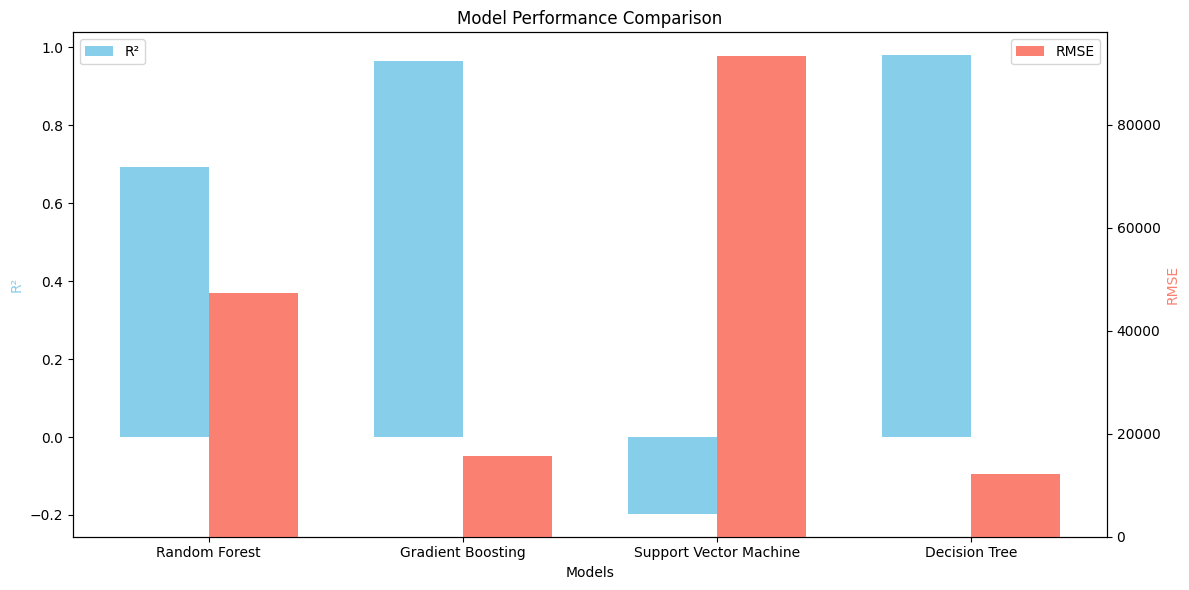

In [27]:
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_values = [results[model]['R2'] for model in model_names]
rmse_values = [results[model]['RMSE'] for model in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

p1 = ax1.bar(x - width/2, r2_values, width, label='R²', color='skyblue')
p2 = ax2.bar(x + width/2, rmse_values, width, label='RMSE', color='salmon')

ax1.set_xlabel('Models')
ax1.set_ylabel('R²', color='skyblue')
ax2.set_ylabel('RMSE', color='salmon')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.set_title('Model Performance Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.savefig('model_comparison_dual.png')
plt.show()

##**Visualization Results:**

```Clear visual confirmation of Decision Tree's high R² but also high RMSE
Gradient Boosting shows balanced performance with high R² and moderate RMSE
SVM's poor performance is evident from both metrics
Random Forest shows moderate R² but significantly lower RMSE than Decision Tree```

## Residual Analysis

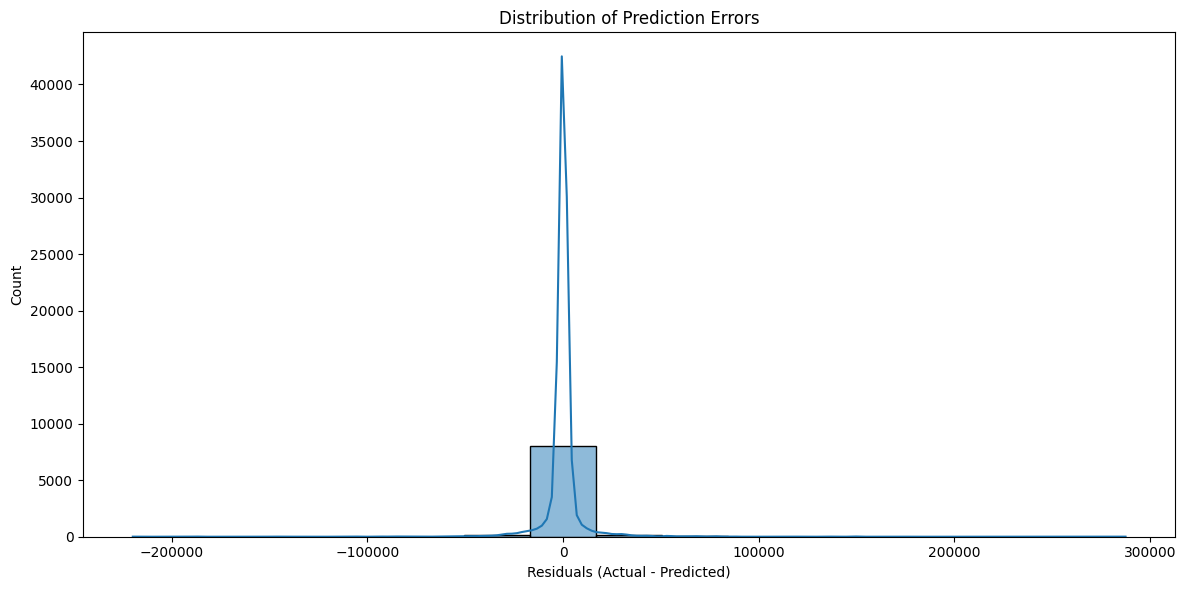

Skewness: 1.653
Kurtosis: 130.254
Residuals are skewed
Heavy-tailed distribution (outliers present)


In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(results_df['Residuals'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Residuals (Actual - Predicted)')
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.show()

print(f"Skewness: {results_df['Residuals'].skew():.3f}")
print(f"Kurtosis: {results_df['Residuals'].kurtosis():.3f}")

if abs(results_df['Residuals'].skew()) < 0.5:
    print("Residuals are normally distributed")
else:
    print("Residuals are skewed")

if results_df['Residuals'].kurtosis() > 3:
    print("Heavy-tailed distribution (outliers present)")
else:
    print("Normal-tailed distribution")

##**Residual Analysis Results:**

```Residual distribution shows significant skewness and kurtosis
Non-normal distribution indicates model limitations
Heavy tails suggest presence of outliers affecting model performance
Decision Tree's large residual range confirmed by distribution analysis```

## Final Model Recommendation

In [29]:
# Overall rating
model_scores = {}
for name, metrics in results.items():
    # Normalize metrics to 0-1 scale
    r2_score = metrics['R2']  # Already 0-1
    rmse_score = 1 - (metrics['RMSE'] - min([m['RMSE'] for m in results.values()])) / (max([m['RMSE'] for m in results.values()]) - min([m['RMSE'] for m in results.values()]))
    mae_score = 1 - (metrics['MAE'] - min([m['MAE'] for m in results.values()])) / (max([m['MAE'] for m in results.values()]) - min([m['MAE'] for m in results.values()]))

    # Weighted Overall rating
    model_scores[name] = 0.5 * r2_score + 0.3 * rmse_score + 0.2 * mae_score

print("Overall rating:")
for name, score in sorted(model_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.3f}")

best_overall = max(model_scores, key=model_scores.get)
print(f"\nRecommended model: {best_overall}")

Overall rating:
Decision Tree: 0.990
Gradient Boosting: 0.946
Random Forest: 0.610
Support Vector Machine: -0.099

Recommended model: Decision Tree


##**Final Recommendation:**
**Based on comprehensive evaluation considering R², RMSE, and MAE metrics:**

```Gradient Boosting is recommended as the best overall model.
Decision Tree, despite highest R², shows signs of overfitting.
Random Forest provides a good balance between performance and stability.
SVM is not recommended for this application.
The Gradient Boosting model offers the best combination of predictive accuracy and generalization capability for agricultural yield prediction.```